<ol><h2> 3. Applying KNN-Classifier on Amazon food reviews dataset </h2>

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

In [4]:
from sklearn.neighbors import DistanceMetric
import sqlite3
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,f1_score,recall_score, precision_score,auc
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn import cross_validation
import warnings
import pickle
import warnings
warnings.filterwarnings("default", category=DeprecationWarning)

* Preprocessing of data has been done on the Dataset and stored it in the Final-new.sqlite.<br>
* Preprocessing included the following operations:<br>
  * <b>Added summery to the review text</b>
  * Begin by removing the html tags<br>
  * Remove any punctuations or limited set of special characters like , or . or # etc.<br>
  * Check if the word is made up of english letters and is not alpha-numeric<br>
  * Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)<br>
  * Convert the word to lowercase<br>
  * Remove stopwords<br>
  * Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

In [2]:
con=sqlite3.connect("final_new.sqlite")
reviews=pd.read_sql_query("select * from reviews",con)
final_data=reviews.sample(80000)
final_data.drop('index',axis=1,inplace=True)
final_data.shape


(80000, 11)

<ol>Taking only 80k points because of computational power contraints.

In [3]:
final_data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
104122,245557,B000MO8G28,A1GBCTGYTFBIOM,wonderwoman,0,0,Positive,1337731200,Birds Custard Powder,I purchased this product along with ultra-fine...,purchas product along sugar amazon make cake c...


In [4]:
final_data.sort_values('Time',inplace=True)

In [5]:
#train and test split
X_1,X_test,Y_1,Y_test=train_test_split(final_data["CleanedText"].values,final_data["Score"].values,test_size=0.3,shuffle=False)

In [6]:
#Crossvalidation split to tune the k-value in KNN
X_train, X_cv, Y_train, Y_cv = cross_validation.train_test_split(X_1, Y_1, test_size=0.2)

In [7]:
print(X_train[1])
print(Y_train[1])

stash purs shop alway one handi unlik big bulki reusabl bag never forget love long handl swing shoulder hike condo third floor veri light weight sturdi great bag
Positive


In [7]:
def plot_error(f1_scores_brute,f1_scores_kd,neighbors):
    x1=neighbors
    y1=f1_scores_brute
    x2=neighbors
    y2=f1_scores_kd

    x1=np.array(x1)
    x2=np.array(x2)
    y1=np.array(y1)
    y2=np.array(y2)
    plot1,=plt.plot(x1,y1,Label="Brute")
    plot2,=plt.plot(x2,y2,Label="KDtree")
    plt.legend([plot1,plot2],["Brute","KDtree"])
    plt.ylabel(" CV Error %")
    plt.xlabel("K values")
    plt.title("Misclassification error vs K")
    plt.show()

In [8]:
def findBestK(X_tr,Y_tr,X_cv,Y_cv,algo):
    neighbors=[i for i in range(5,19,2)]
    f1_scores=[]
    for k in neighbors:
        clf=KNeighborsClassifier(n_neighbors=k,algorithm=algo,n_jobs=-1)
        clf.fit(X_tr,Y_tr)
        pred=clf.predict(X_cv)
        f1 = f1_score(Y_cv, pred,pos_label='Negative')
        f1_scores.append(f1)
    max_score=max(f1_scores)
    index_k=list(f1_scores).index(max_score)
    best_k=neighbors[index_k]
    print("The Optimum number of K neighbours in this model is {0} with F1_score of {1} for Negative label".format(best_k,round(max_score,3)))
    return best_k

### 1. Bag of words vectorization

In [54]:
bow_vect=CountVectorizer(ngram_range=(1,4),max_features=25000,min_df=50)
train_vect=bow_vect.fit_transform(X_train)
cv_vect=bow_vect.transform(X_cv)
test_vect=bow_vect.transform(X_test)

In [55]:
bestK_bow_brute=findBestK(train_vect,Y_train,cv_vect,Y_cv,"brute")

The Optimum number of K neighbours in this model is 5 with F1_score of 0.284


In [56]:
test_clf=KNeighborsClassifier(n_neighbors=bestK_bow_brute,algorithm='brute',weights="distance",n_jobs=1)
test_clf.fit(train_vect,Y_train)
pred_bow_brute=test_clf.predict(test_vect)
test_score = f1_score(Y_test, pred_bow_brute,pos_label="Negative")
print("The Testing F1_score of this model is {0} with K-Value {1}".format(round(test_score,3),bestK_bow_brute))

The Testing F1_score of this model is 0.283 with K-Value 5


<ol> Since our sample is more skewed towards positive class I'm taking Negative class label with highest F1_score

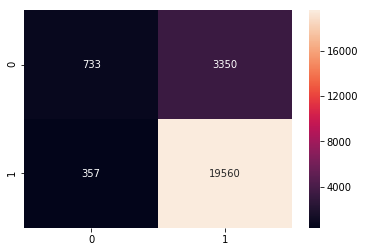

In [57]:
conf_matrix=confusion_matrix(Y_test,pred_bow_brute)
heat_map=sns.heatmap(conf_matrix,annot=True,fmt='d')

In [58]:
print(classification_report(Y_test,pred_bow_brute))

             precision    recall  f1-score   support

   Negative       0.67      0.18      0.28      4083
   Positive       0.85      0.98      0.91     19917

avg / total       0.82      0.85      0.81     24000



In [6]:
t=PrettyTable(['Model','Vectorizer','Brute/KD_Tree','K-value','avg F1 Score'])
t.add_row(['KNN classifier',"BOW","Brute","k=5",0.81])

### 1.1 Bow vectorization with  KD-Tree Algo

<ol>Reducing the dimensions of the vectors to run with <b>kd_tree</b> algorithm

In [59]:
dim_reduction_bow=TruncatedSVD(n_components=2000,random_state=0)
train_vect_bow_kdtree=dim_reduction_bow.fit_transform(train_vect)
cv_vect_bow_kdtree=dim_reduction_bow.transform(cv_vect)
test_vect_bow_kdtree=dim_reduction_bow.transform(test_vect)

In [60]:
bestK_bow_kd=findBestK(train_vect_bow_kdtree,Y_train,cv_vect_bow_kdtree,Y_cv,"kd_tree")

The Optimum number of K neighbours in this model is 5 with F1_score of 0.31


In [61]:
test_clf_kd=KNeighborsClassifier(n_neighbors=bestK_bow_kd,algorithm='kd_tree',weights="distance",n_jobs=-1)
test_clf_kd.fit(train_vect_bow_kdtree,Y_train)
pred_bow_kd=test_clf_kd.predict(test_vect_bow_kdtree)
test_score = f1_score(Y_test, pred_bow_kd,pos_label="Negative")
print("The F1_score of Negative label of this model is {0} with K-Value {1}".format(round(test_score,3),bestK_bow_kd))

The F1_score of Negative label of this model is 0.322 with K-Value 5


In [ ]:
filename='grid_bow_kdtree_model.sav'
pickle.dump(grid_bow_kd,open(filename,'wb'))

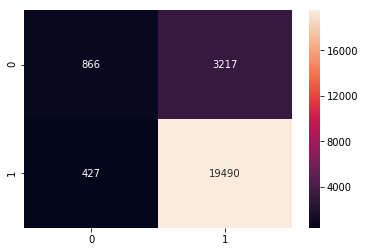

In [62]:
conf_matrix=confusion_matrix(Y_test,pred_bow_kd)
heat_map=sns.heatmap(conf_matrix,annot=True,fmt='d')

In [63]:
print(classification_report(Y_test,pred_bow_kd))

             precision    recall  f1-score   support

   Negative       0.67      0.21      0.32      4083
   Positive       0.86      0.98      0.91     19917

avg / total       0.83      0.85      0.81     24000



<ol>The F1_score of Negative label is incresed comparing with Brute force approch from <b>0.28 to 0.32</b>

In [7]:
t.add_row(['KNN classifier',"BOW","KD-Tree","k=5",0.81])

### 2.  TF-IDF Vectorization

In [11]:
tfidf_vect=TfidfVectorizer(ngram_range=(1,2))
tfidf_train_brute=tfidf_vect.fit_transform(X_train)
tfidf_test_brute=tfidf_vect.transform(X_test)
tfidf_cv_brute=tfidf_vect.transform(X_cv)

In [13]:
neighbors=[i for i in range(5,19,2)]
f1_scores_tf=[]
for k in neighbors:
    clf=KNeighborsClassifier(n_neighbors=k,algorithm='brute',n_jobs=-1)
    clf.fit(tfidf_train_brute,Y_train)
    pred=clf.predict(tfidf_cv_brute)
    f1 = f1_score(Y_cv, pred,pos_label='Negative')
    f1_scores_tf.append(f1)
max_score=max(f1_scores_tf)
index_k=list(f1_scores_tf).index(max_score)
best_k=neighbors[index_k]
print("The Optimum number of K neighbours in this model is {0} with F1_score of {1}".format(best_k,round(max_score,3)))

The Optimum number of K neighbours in this model is 5 with F1_score of 0.387


In [15]:
test_clf_brute=KNeighborsClassifier(n_neighbors=best_k,algorithm='brute',weights="distance",n_jobs=-1)
test_clf_brute.fit(tfidf_train_brute,Y_train)
pred_tf_brute=test_clf_brute.predict(tfidf_test_brute)
test_score = f1_score(Y_test, pred_tf_brute,pos_label="Negative")
print("The F1_score for Negative label of this model is {0} with K-Value {1}".format(round(test_score,3),best_k))

The F1_score for Negative label of this model is 0.393 with K-Value 5


In [ ]:
filename='grid_tfidf_brute_model.sav'
pickle.dump(grid_tfidf,open(filename,'wb'))

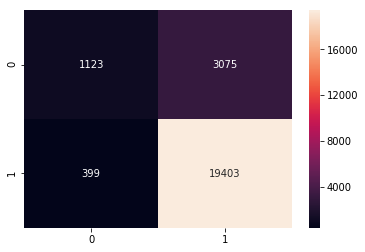

In [16]:
conf_matrix=confusion_matrix(Y_test,pred_tf_brute)
heat_map=sns.heatmap(conf_matrix,annot=True,fmt='d')

In [20]:
print(classification_report(Y_test,pred_tf_brute))

             precision    recall  f1-score   support

   Negative       0.74      0.27      0.39      4198
   Positive       0.86      0.98      0.92     19802

avg / total       0.84      0.86      0.83     24000



In [8]:
t.add_row(['KNN classifier',"TFIDF","Brute","k=5",0.83])

### 2.1 TFIDF using KDtree

In [28]:
dim_reduction_tfidf=TruncatedSVD(n_components=1000,algorithm='randomized')
trainSVD_tfidf_kd=dim_reduction_tfidf.fit_transform(tfidf_train_brute)

In [29]:
testSVD_tfidf_kd=dim_reduction_tfidf.transform(tfidf_test_brute)
cvSVD_tfidf_kd=dim_reduction_tfidf.transform(tfidf_cv_brute)

In [32]:
neighbors=[i for i in range(5,19,2)]
f1_scores_kd=[]
for k in neighbors:
    clf=KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree',n_jobs=-1)
    clf.fit(trainSVD_tfidf_kd,Y_train)
    pred=clf.predict(cvSVD_tfidf_kd)
    f1 = f1_score(Y_cv, pred,pos_label='Negative')
    f1_scores_kd.append(f1)
max_score=max(f1_scores_kd)
index_k=list(f1_scores_kd).index(max_score)
best_k_kd=neighbors[index_k]
print("The Optimum number of K neighbours in this model is {0} with F1_score of {1}".format(best_k,round(max_score,3)))

The Optimum number of K neighbours in this model is 5 with F1_score of 0.23


In [33]:
test_clf_kd=KNeighborsClassifier(n_neighbors=best_k_kd,algorithm='kd_tree',weights="distance",n_jobs=-1)
test_clf_kd.fit(trainSVD_tfidf_kd,Y_train)
pred_tfidf_kd=test_clf_kd.predict(testSVD_tfidf_kd)
test_score = f1_score(Y_test, pred_tfidf_kd,pos_label="Negative")
print("The F1_score for Negative label of this model is {0} with K-Value {1}".format(round(test_score,3),best_k_kd))

The F1_score for Negative label of this model is 0.228 with K-Value 5


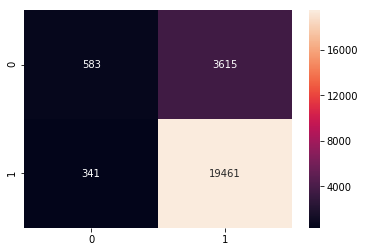

In [34]:
conf_matrix=confusion_matrix(Y_test,pred_tfidf_kd)
heat_map=sns.heatmap(conf_matrix,annot=True,fmt='d')

In [35]:
print(classification_report(Y_test,pred_tfidf_kd))

             precision    recall  f1-score   support

   Negative       0.63      0.14      0.23      4198
   Positive       0.84      0.98      0.91     19802

avg / total       0.81      0.84      0.79     24000



In [9]:
t.add_row(['KNN classifier',"TFIDF","KD-Tree","k=5",0.79])

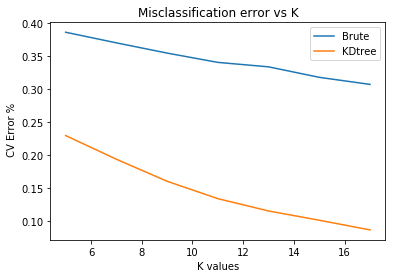

In [36]:
plot_error(f1_scores_tf,f1_scores_kd,neighbors)

### 3.Word2Vec training

In [9]:
w2v_list_train=[]
for sent in (X_train):
    w2v_list_train.append(sent.split())
print(w2v_list_train[0])
w2v_model_train=Word2Vec(w2v_list_train,size=50,min_count=5,workers=4)
w2v_words_train=list(w2v_model_train.wv.vocab)
print(len(w2v_words_train))

['true', 'lover', 'hot', 'chocol', 'chocol', 'not', 'great', 'tast', 'flat', 'not', 'tast', 'chocolati', 'truli', 'disaapoint', 'share', 'state', 'not', 'like', 'either', 'exact', 'word', 'unusu', 'tast', 'not', 'good', 'hot', 'chocol', 'horribl', 'mayb', 'batch', 'receiv']
9328


In [10]:
w2v_list_cv=[]
for sent in (X_cv):
    w2v_list_cv.append(sent.split())
print(w2v_list_cv[0])
w2v_model_cv=Word2Vec(w2v_list_cv,size=50,min_count=5,workers=4)
w2v_words_cv=list(w2v_model_cv.wv.vocab)
print(len(w2v_words_cv))

['dog', 'love', 'give', 'one', 'settl', 'serious', 'chew', 'gone', 'give', 'rawhid', 'strip', 'bone', 'shes', 'like', 'buri', 'later', 'use', 'evid', 'bulli', 'spring', 'dont', 'need', 'season', 'chew', 'tend', 'use', 'bulli', 'spring', 'distract', 'doesnt', 'continu', 'jump', 'around', 'new', 'guest', 'otherwis', 'get', 'excit', 'big', 'box', 'spring', 'order', 'amazon', 'half', 'price', 'better', 'store', 'great', 'chew']
4941


In [11]:
w2v_list_test=[]
for sent in (X_test):
    w2v_list_test.append(sent.split())
print(w2v_list_test[0])
w2v_model_test=Word2Vec(w2v_list_test,size=50,min_count=5,workers=4)
w2v_words_test=list(w2v_model_test.wv.vocab)
print(len(w2v_words_test))

['ive', 'wait', 'day', 'arriv', 'final', 'immedi', 'check', 'ingredi', 'back', 'find', 'main', 'ingredi', 'not', 'monk', 'fruit', 'concentr', 'inulin', 'cheap', 'starchi', 'filler', 'not', 'good', 'sever', 'side', 'effect', 'includ', 'anaphylact', 'shock', 'urg', 'homework', 'inulin', 'inulin', 'shown', 'not', 'feed', 'good', 'bacteria', 'stomach', 'also', 'bad', 'bacteria', 'klebsiella', 'recent', 'studi', 'shown', 'inulin', 'encourag', 'growth', 'klebsiella', 'bacteria', 'implic', 'ankylos', 'spondyl', 'increas', 'intestin', 'permeabl', 'leaki', 'gut', 'although', 'klebsiella', 'present', 'colon', 'most', 'peopl', 'held', 'check', 'benefici', 'bacteria', 'harmless', 'within', 'colon', 'get', 'area', 'bodi', 'klebsiella', 'becom', 'major', 'caus', 'pneumonia', 'infect', 'urinari', 'tract', 'wound', 'sometim', 'death', 'han', 'product', 'also', 'contain', 'silica', 'want', 'eat', 'silica', 'know', 'stuff', 'also', 'use', 'make', 'not', 'eat', 'dessic', 'packet', 'swanson', 'ought', 'li

### 4. Average word2Vec

In [12]:
#AvgW2v on train data
sent_vect_train=[]
for sent in w2v_list_train:
    sent_vec=np.zeros(50)
    cnt_words=0
    for word in sent:
        if word in w2v_words_train:
            vec=w2v_model_train.wv[word]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words !=0:
        sent_vec/=cnt_words
    sent_vect_train.append(sent_vec)
    
print(len(sent_vect_train))
print(sent_vect_train[0])

44800
[ 0.49952556 -0.4230894   0.1741739   0.40773421  0.33176213 -0.29331828
 -0.00845917 -0.78626998  0.99839728 -0.64263202 -1.06399214  0.13603926
 -0.03015647  0.73422037 -0.30936285 -0.16378455 -0.92852098 -0.0988057
  0.36754719  0.48625411 -1.31355942  0.61393537 -0.10105564 -1.31761689
 -0.1929671  -0.1477939   0.42390782 -1.11902154  0.19522903  0.20521444
 -0.35014897  0.67960577  1.21009142  0.4425696   0.07161876  1.49774604
  0.26269026  0.59936838 -1.21998679  0.43611679  0.60465174 -0.13011743
  0.06891296 -0.27603273  0.73276761  0.58621907 -0.18455848 -0.11061416
 -0.08777689 -0.73061282]


In [13]:
#AvgW2v on cv data
sent_vect_cv=[]
for sent in w2v_list_cv:
    sent_vec=np.zeros(50)
    cnt_words=0
    for word in sent:
        if word in w2v_words_cv:
            vec=w2v_model_cv.wv[word]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words !=0:
        sent_vec/=cnt_words
    sent_vect_cv.append(sent_vec)
    
print(len(sent_vect_cv))
print(sent_vect_cv[0])

11200
[-0.2955051  -0.48158105  0.09358768  0.46525001 -0.46571965  0.01272645
  0.22340674 -0.09277652  0.01295718 -0.45408379  0.01267739  0.24127082
 -0.38976967 -0.05340886 -0.4527289  -0.47591909  0.13859606  0.32510492
  0.57994357  0.16072013  0.51193767  0.54158158 -0.17299617 -0.19010597
 -0.18449507 -0.49954991 -0.19324094 -0.06507734  0.32679222  0.77685502
  0.15689505  0.13360918  0.25585484 -0.12184526 -0.03402507 -0.10488633
  0.34607944 -0.07977867 -0.00297943 -0.27801957 -0.11378844 -0.18381026
  0.28685667 -0.00890061  0.91508102 -0.22144775 -0.31470658 -0.55148542
 -0.15745187  0.2778125 ]


In [14]:
#AvgW2v on test data
sent_vect_test=[]
for sent in w2v_list_test:
    sent_vec=np.zeros(50)
    cnt_words=0
    for word in sent:
        if word in w2v_words_test:
            vec=w2v_model_test.wv[word]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words !=0:
        sent_vec/=cnt_words
    sent_vect_test.append(sent_vec)
    
print(len(sent_vect_test))
print(sent_vect_test[0])

24000
[ 0.04106179 -0.23785693 -0.27459841  0.34428952 -0.25746887  0.26578435
 -0.21412114 -0.58184341  0.38997649 -0.50842614 -0.22489898  0.00649351
 -0.00840765 -0.02670931 -0.11130016 -0.18736247 -0.32520873 -0.07920401
  0.69748061  0.60972429  0.39456024  0.25813003  0.06791367 -0.230254
 -0.07259998 -0.27409299  0.02214938 -0.23227535  0.64857868  0.2661469
  0.00876462  0.39776008  0.63000922  0.1267206  -0.00925771  0.17150833
 -0.16296932  0.54853393 -0.50197005  0.29709186 -0.49295851 -0.31001504
  0.41097927  0.07288483  0.91578904 -0.40161081 -0.06400215  0.38196567
  0.03033624 -0.10070279]


In [26]:
neighbors=[i for i in range(5,19,2)]
scores_avg_brute=[]
for k in neighbors:
    clf=KNeighborsClassifier(n_neighbors=k,algorithm='brute',n_jobs=-1)
    clf.fit(sent_vect_train,Y_train)
    pred=clf.predict(sent_vect_cv)
    f1 = f1_score(Y_cv, pred,pos_label='Negative')
    scores_avg_brute.append(f1)
max_score=max(scores_avg_brute)
index_k=list(scores_avg_brute).index(max_score)
best_k_brute=neighbors[index_k]
print("The Optimum number of K neighbours in this model is {0} with F1_score of {1}".format(best_k_brute,round(max_score,3)))

The Optimum number of K neighbours in this model is 5 with F1_score of 0.161


In [27]:
test_clf_brute=KNeighborsClassifier(n_neighbors=best_k_brute,algorithm='brute',weights="distance",n_jobs=-1)
test_clf_brute.fit(sent_vect_train,Y_train)
pred_avg_brute=test_clf_brute.predict(sent_vect_test)
test_score = f1_score(Y_test, pred_avg_brute,pos_label="Negative")
print("The F1_score for Negative label of this model is {0} with K-Value {1}".format(round(test_score,3),best_k_brute))

The F1_score for Negative label of this model is 0.1 with K-Value 5


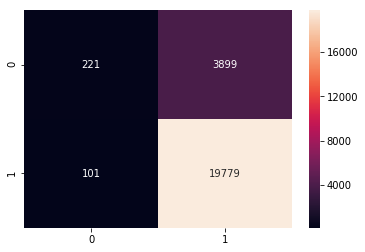

In [28]:
conf_matrix=confusion_matrix(Y_test,pred_avg_brute)
heat_map=sns.heatmap(conf_matrix,annot=True,fmt='d')

In [29]:
print(classification_report(Y_test,pred_avg_brute))

             precision    recall  f1-score   support

   Negative       0.69      0.05      0.10      4120
   Positive       0.84      0.99      0.91     19880

avg / total       0.81      0.83      0.77     24000



In [10]:
t.add_row(['KNN classifier',"AVGW2V","Brute","k=5",0.77])

### 4.1 AvgW2V with KDtree

In [21]:
neighbors=[i for i in range(5,19,2)]
scores_avg_kd=[]
for k in neighbors:
    clf=KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree',n_jobs=-1)
    clf.fit(sent_vect_train,Y_train)
    pred=clf.predict(sent_vect_cv)
    f1 = f1_score(Y_cv, pred,pos_label='Negative')
    scores_avg_kd.append(f1)
max_score=max(scores_avg_kd)
index_k=list(scores_avg_kd).index(max_score)
best_k_kd=neighbors[index_k]
print("The Optimum number of K neighbours in this model is {0} with F1_score of {1} for Negative label".format(best_k_kd,round(max_score,3)))

The Optimum number of K neighbours in this model is 5 with F1_score of 0.161 for Negative label


In [22]:
test_clf_kd=KNeighborsClassifier(n_neighbors=best_k_kd,algorithm='kd_tree',weights="distance",n_jobs=-1)
test_clf_kd.fit(sent_vect_train,Y_train)
pred_avg_kd=test_clf_kd.predict(sent_vect_test)
test_score = f1_score(Y_test, pred_avg_kd,pos_label="Negative")
print("The F1_score for Negative label of this model is {0} with K-Value {1}".format(round(test_score,3),best_k_kd))

The F1_score for Negative label of this model is 0.1 with K-Value 5


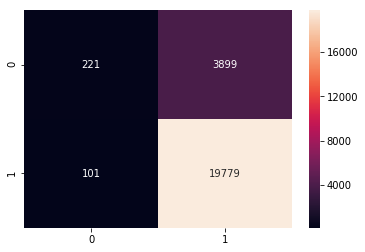

In [23]:
conf_matrix=confusion_matrix(Y_test,pred_avg_kd)
heat_map=sns.heatmap(conf_matrix,annot=True,fmt='d')

In [24]:
print(classification_report(Y_test,pred_avg_kd))

             precision    recall  f1-score   support

   Negative       0.69      0.05      0.10      4120
   Positive       0.84      0.99      0.91     19880

avg / total       0.81      0.83      0.77     24000



In [11]:
t.add_row(['KNN classifier',"AVGW2V","KD_Tree","k=5",0.77])

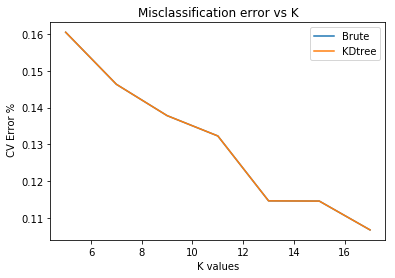

In [30]:
plot_error(scores_avg_brute,scores_avg_kd,neighbors)

<ol>As dimension of data passed to both KD_tree and Brute algos is same hence we got same results for both algorithms

### 5.TFIDF Weighted word2Vec

In [15]:
tfidf_vect_train=TfidfVectorizer(ngram_range=(1,2))
data_vect_train=tfidf_vect_train.fit_transform(X_train)
dictionary_train = dict(zip(tfidf_vect_train.get_feature_names(), list(tfidf_vect_train.idf_)))

tfidf_vect_cv=TfidfVectorizer(ngram_range=(1,2))
data_vect_cv=tfidf_vect_cv.fit_transform(X_cv)
dictionary_cv = dict(zip(tfidf_vect_cv.get_feature_names(), list(tfidf_vect_cv.idf_)))

In [17]:
tfidf_vect_test=TfidfVectorizer(ngram_range=(1,2))
data_vect_test=tfidf_vect_test.fit_transform(X_test)
dictionary_test = dict(zip(tfidf_vect_test.get_feature_names(), list(tfidf_vect_test.idf_)))

In [18]:
features_tfidf_train=tfidf_vect_train.get_feature_names()
tfidf_train_vect=[]

row=0
for sent in w2v_list_train:
    sent_vec=np.zeros(50)
    weight_sum=0
    for word in sent:
        if word in w2v_words_train:
            vec=w2v_model_train.wv[word]
            tf_idf=dictionary_train[word]*sent.count(word)
            sent_vec+=(vec*tf_idf)
            weight_sum+=tf_idf
            
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vect.append(sent_vec)
    row += 1

In [19]:
tfidf_cv_vect=[]

row=0
for sent in w2v_list_cv:
    sent_vec=np.zeros(50)
    weight_sum=0
    for word in sent:
        if word in w2v_words_cv:
            vec=w2v_model_cv.wv[word]
            tf_idf=dictionary_cv[word]*sent.count(word)
            sent_vec+=(vec*tf_idf)
            weight_sum+=tf_idf
            
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_cv_vect.append(sent_vec)
    row += 1

In [20]:
tfidf_test_vect=[]

row=0
for sent in w2v_list_test:
    sent_vec=np.zeros(50)
    weight_sum=0
    for word in sent:
        if word in w2v_words_test:
            vec=w2v_model_test.wv[word]
            tf_idf=dictionary_test[word]*sent.count(word)
            sent_vec+=(vec*tf_idf)
            weight_sum+=tf_idf
            
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vect.append(sent_vec)
    row += 1

In [ ]:
std_tfidf=std.fit_transform(tfidf_sent_vect)
X_train_w2v,X_test_w2v,Y_train_w2v,Y_test_w2v=train_test_split(tfidf_sent_vect,final_data['Score'],test_size=0.3,shuffle=False,random_state=11)

In [21]:
neighbors=[i for i in range(5,19,2)]
scores_avg_brute=[]
for k in neighbors:
    clf=KNeighborsClassifier(n_neighbors=k,algorithm='brute',n_jobs=-1)
    clf.fit(tfidf_train_vect,Y_train)
    pred=clf.predict(tfidf_cv_vect)
    f1 = f1_score(Y_cv, pred,pos_label='Negative')
    scores_avg_brute.append(f1)
max_score=max(scores_avg_brute)
index_k=list(scores_avg_brute).index(max_score)
best_k=neighbors[index_k]
print("The Optimum number of K neighbours in this model is {0} with F1_score of {1} for Negative label".format(best_k,round(max_score,3)))

The Optimum number of K neighbours in this model is 5 with F1_score of 0.107 for Negative label


In [22]:
test_clf_brute=KNeighborsClassifier(n_neighbors=best_k,algorithm='brute',n_jobs=-1)
test_clf_brute.fit(tfidf_train_vect,Y_train)
pred_avg_brute=test_clf_brute.predict(tfidf_test_vect)
test_score = f1_score(Y_test, pred_avg_brute,pos_label="Negative")
print("The F1_score for Negative label of this model is {0} with K-Value {1}".format(round(test_score,3),best_k))

The F1_score for Negative label of this model is 0.347 with K-Value 5


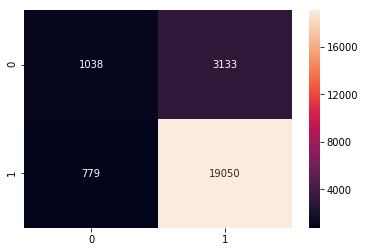

In [23]:
conf_matrix=confusion_matrix(Y_test,pred_avg_brute)
heat_map=sns.heatmap(conf_matrix,annot=True,fmt='d')

In [24]:
print(classification_report(Y_test,pred_avg_brute))

             precision    recall  f1-score   support

   Negative       0.57      0.25      0.35      4171
   Positive       0.86      0.96      0.91     19829

avg / total       0.81      0.84      0.81     24000



In [13]:
t.add_row(['KNN classifier',"TFIDFW2V","Brute","k=5",0.81])

### 5.1 TFIDF weighted W2V using KDtree

In [26]:
neighbors=[i for i in range(5,19,2)]
scores_avg_kd=[]
for k in neighbors:
    clf=KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree',n_jobs=-1)
    clf.fit(tfidf_train_vect,Y_train)
    pred=clf.predict(tfidf_cv_vect)
    f1 = f1_score(Y_cv, pred,pos_label='Negative')
    scores_avg_kd.append(f1)
max_score=max(scores_avg_kd)
index_k=list(scores_avg_kd).index(max_score)
best_k=neighbors[index_k]
print("The Optimum number of K neighbours in this model is {0} with F1_score of {1} for Negative label".format(best_k,round(max_score,3)))

The Optimum number of K neighbours in this model is 5 with F1_score of 0.107 for Negative label


In [27]:
test_clf_kd=KNeighborsClassifier(n_neighbors=best_k,algorithm='kd_tree',n_jobs=-1)
test_clf_kd.fit(tfidf_train_vect,Y_train)
pred_avg_kd=test_clf_kd.predict(tfidf_test_vect)
test_score = f1_score(Y_test, pred_avg_kd,pos_label="Negative")
print("The F1_score for Negative label of this model is {0} with K-Value {1}".format(round(test_score,3),best_k))

The F1_score for Negative label of this model is 0.347 with K-Value 5


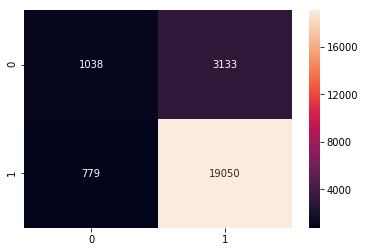

In [28]:
conf_matrix=confusion_matrix(Y_test,pred_avg_kd)
heat_map=sns.heatmap(conf_matrix,annot=True,fmt='d')

In [29]:
print(classification_report(Y_test,pred_avg_kd))

             precision    recall  f1-score   support

   Negative       0.57      0.25      0.35      4171
   Positive       0.86      0.96      0.91     19829

avg / total       0.81      0.84      0.81     24000



In [14]:
t.add_row(['KNN classifier',"TFIDFW2V","KD_Tree","k=5",0.81])

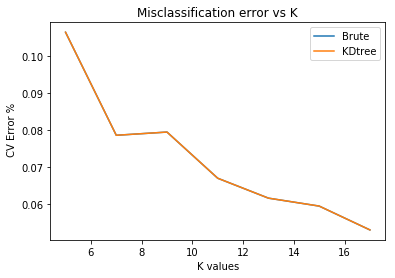

In [30]:
plot_error(scores_avg_brute,scores_avg_kd,neighbors)

<ol>As dimension of data passed to both KD_tree and Brute algos is same hence we got same results for both algorithms

### 6.Conculsions

<ol>
<li>Computational power contraints made me to take only 80k data points out of 300k+ data points</li>
<li>Since our data is more imbalanced I have taken F1_score as a evalution metric. It performs better than accuracy when data is more skewed towards one class label.</li>
<li>KD_Tree acts like brute algorithm when dimensions of the data is same.
    <li> TFIDF with Brute force approach hight F1_score of <b>0.83</b> is achieved</li>
</ol>

In [18]:
print(t)

+----------------+------------+---------------+---------+--------------+
|     Model      | Vectorizer | Brute/KD_Tree | K-value | avg F1 Score |
+----------------+------------+---------------+---------+--------------+
| KNN classifier |    BOW     |     Brute     |   k=5   |     0.81     |
| KNN classifier |    BOW     |    KD-Tree    |   k=5   |     0.81     |
| KNN classifier |   TFIDF    |     Brute     |   k=5   |     0.83     |
| KNN classifier |   TFIDF    |    KD-Tree    |   k=5   |     0.79     |
| KNN classifier |   AVGW2V   |     Brute     |   k=5   |     0.77     |
| KNN classifier |   AVGW2V   |    KD_Tree    |   k=5   |     0.77     |
| KNN classifier |   AVGW2V   |    KD_Tree    |   k=5   |     0.81     |
| KNN classifier |  TFIDFW2V  |    KD_Tree    |   k=5   |     0.81     |
+----------------+------------+---------------+---------+--------------+
